# Why do people delay book return

## Fast analysis POC

In [1090]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Problem statement

We'd like you to analyze the library data located here and help us build a model to predict the <b>likelihood of a late return of any book at checkout time</b>? 
- Are there any factors you can find that are connected with late returns? 
- What would you recommend the library do to mitigate the risks you find? 
- How would you present your findings to them to get buy-in? 
<br>
<br>

The data has the following schema, each table is represented by one CSV file with the matching name.

![](schema.png)

### Before beginning

The most basic data preparing steps you can find in the following files:

- `clean_target_varaible.py`
- `preprocessing.py`

It's important to note, that data were "dirty", so it took a time to prepare it.

All the paths and config you can find there: `config.py`

In [1022]:
## Before proceeding run following lines
# !python clean_target_varaible.py
# !python preprocessing.py

In [1023]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from config import Config, DataEnc
import numpy as np

df = pd.read_parquet(Config.PREPARED_DATASET_FNAME)

### Missing values

Let's look at missing values. I split all the variables into several groups depending on how they might be encoded or analyzed.
We can handle missings in several ways. As for categorical variables I decided to create one more category "Unknown" and put all the missings there. As for numerical, I decided to drop missings, because we lose about 100 observations. It's not much but ideally, they might be filled by for example predicting them.

In [1024]:
df[
    DataEnc.TARGET
    + DataEnc.CAT_ENC 
    + DataEnc.NUM_ENC
].columns 

Index(['is_delayed', 'name_lib', 'city_lib', 'region', 'publisher',
       'categories', 'city_customer', 'state', 'gender', 'education',
       'occupation', 'price', 'pages', 'book_age_days', 'customer_age_days'],
      dtype='object')

In [1025]:
df.city_lib = df.city_lib.fillna(Config.MISSING_COMMON)
df.region = df.region.fillna(Config.MISSING_COMMON)
df.publisher = df.publisher.fillna(Config.MISSING_COMMON)
df.categories = df.categories.fillna(Config.MISSING_COMMON)
df.state = df.state.fillna(Config.MISSING_COMMON)
df.gender = df.gender.fillna(Config.MISSING_COMMON)
df.education = df.education.fillna(Config.MISSING_COMMON)
df.occupation = df.occupation.fillna(Config.MISSING_COMMON)


df = df.dropna(subset=["price", "book_age_days", "customer_age_days"]).reset_index(drop=True)

### EDA

Let's look at how our final data is distributed. Are there any outliers

#### Numerical variables

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'pages'}>],
       [<AxesSubplot:title={'center':'book_age_days'}>,
        <AxesSubplot:title={'center':'customer_age_days'}>]], dtype=object)

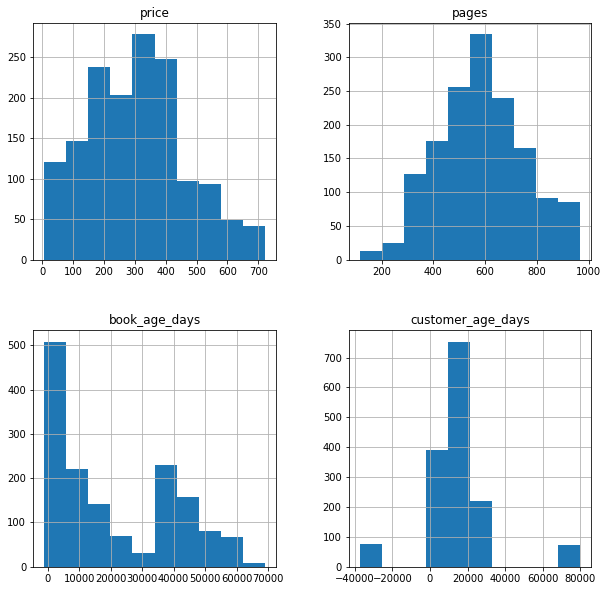

In [1026]:
df[DataEnc.NUM_ENC].hist(figsize=(10, 10))

As we can see above distributions are more or less normal, except for negative values of customer_age_days. It might be an encoding problem on raw data, let's remove it.

In [1096]:
df = df[df['customer_age_days'] > 0].reset_index(drop=True)

### Categorical variables

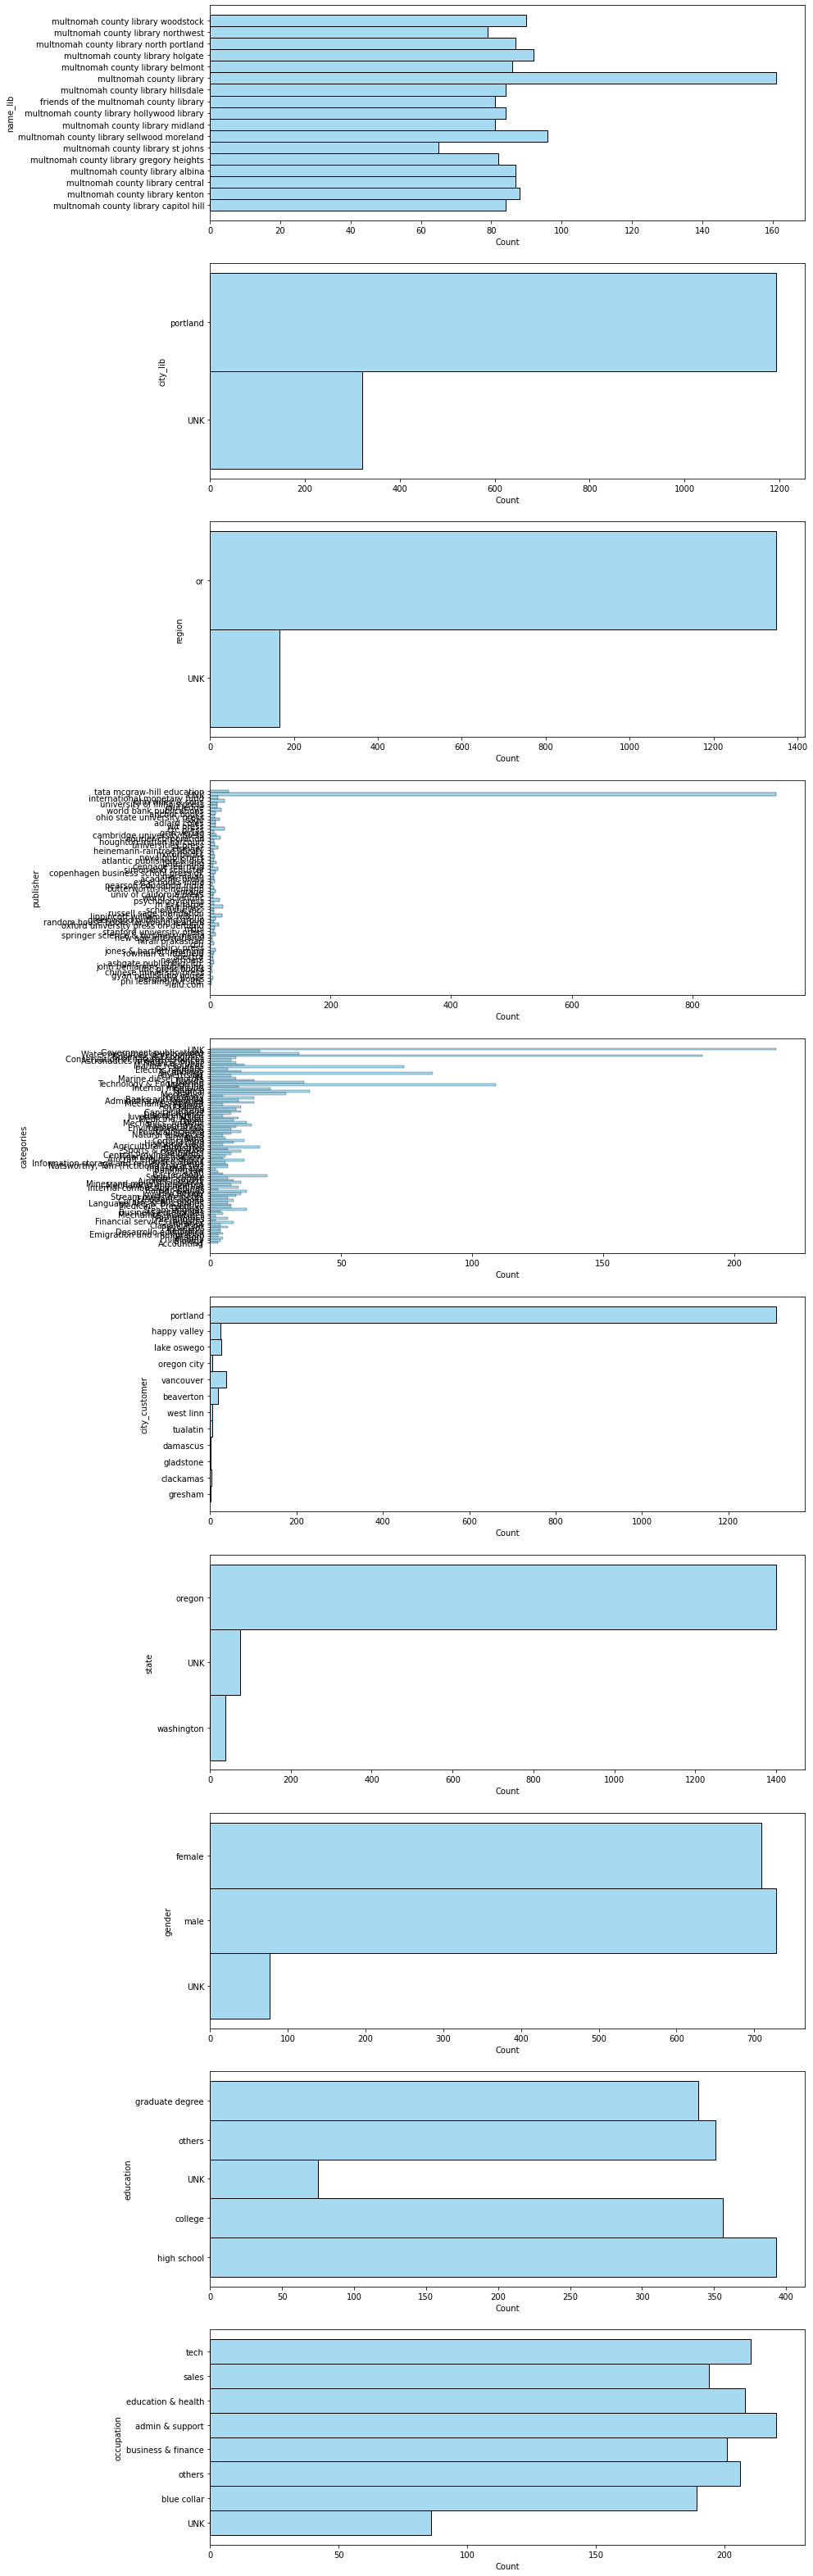

In [1027]:
fig, axs = plt.subplots(10, 1, figsize=(13, 57))
c = 0
for i in df[DataEnc.CAT_ENC].columns:
    sns.histplot(data=df, y=i, kde=False, color="skyblue", ax=axs[c])
    c+=1

As we can see above, categorical variables are unbalanced, which may influence model fit. Also, we can notice that some variables contain too many categories. It's better to use target encoding for such variables.

### Target variable

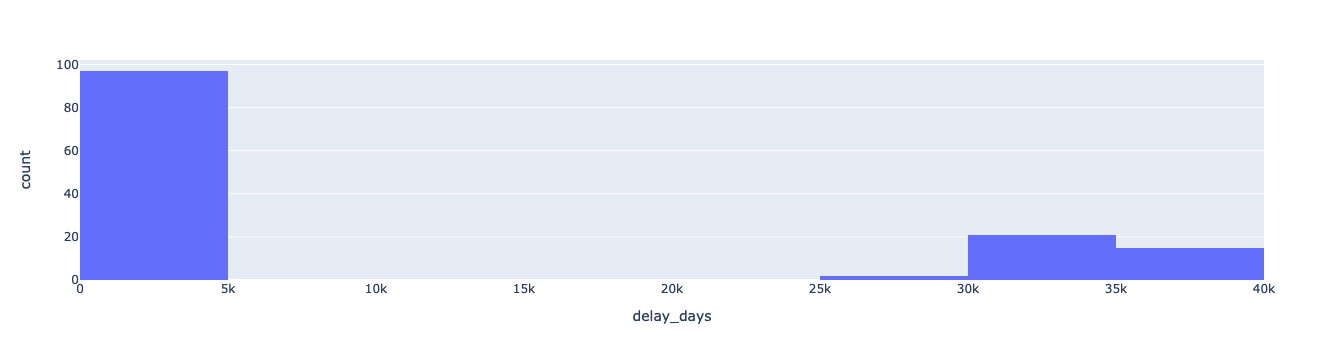

In [1097]:
fig = px.histogram(df[(df["delay_days"]) & (df["delay_days"] > DELAY_DAY)], x="delay_days")
fig.show()

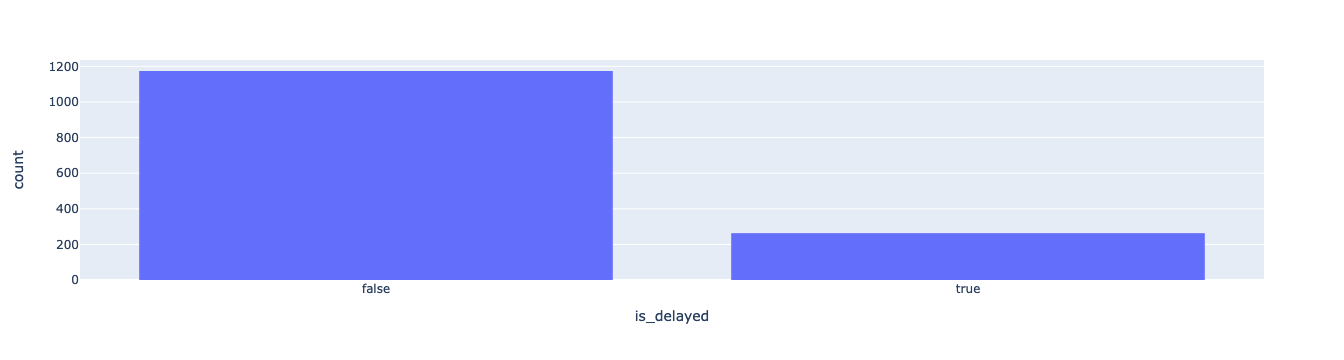

In [1098]:
fig = px.histogram(df, x="is_delayed")
fig.show()

As we can see above the data is extremely imbalanced, it should be handled somehow. Moreover, in the first plot, we can see a lot of outliers that might be interesting to dive deep into.

### Feature encoding

In this research, we'll use target encoding for variables that contain a lot of categories. And for the rest, we'll use standard OHE

In [1030]:
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import OneHotEncoder

target_enc_vars = ["categories", "publisher", "name_lib"]
OHE_enc_vars = [i for i in DataEnc.CAT_ENC if not i in target_enc_vars]

In [1031]:
ohe = OneHotEncoder(handle_unknown='ignore')
te = TargetEncoder()

ohe.fit(df[OHE_enc_vars].astype(str))
te.fit(df[target_enc_vars].astype(str), df[DataEnc.TARGET])

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


TargetEncoder(cols=['categories', 'publisher', 'name_lib'])

In [1032]:
X1 = ohe.transform(df[OHE_enc_vars])
X2 = te.transform(df[target_enc_vars].astype(str))

In [1034]:
my_columns = []
for ohe_cols, col in zip(ohe.categories_, df[OHE_enc_vars].columns):
    for val in ohe_cols:
        if val == "None" or val == Config.MISSING_COMMON :
            my_columns.append(f"{col}_{val}")
        else:
            my_columns.append(val)
my_columns = my_columns + list(X2.columns) + list(df[DataEnc.NUM_ENC].columns)

In [1035]:
X = pd.DataFrame(np.column_stack((X1.todense(), X2.to_numpy(), df[DataEnc.NUM_ENC].to_numpy())), columns=my_columns).reset_index(drop=True)
y = df[DataEnc.TARGET].reset_index(drop=True)

In [1036]:
X.head()

,city_lib_UNK,portland,region_UNK,or,city_customer_None,beaverton,clackamas,damascus,gladstone,gresham,...,others,sales,tech,categories,publisher,name_lib,price,pages,book_age_days,customer_age_days
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.222222,0.193548,0.133333,416.99,752.0,4531.0,19483.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.222222,0.193548,0.202532,416.99,752.0,4600.0,13418.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.222222,0.193548,0.160920,416.99,752.0,4429.0,14862.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.222222,0.193548,0.152174,416.99,752.0,4692.0,19745.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.222222,0.193548,0.162791,416.99,752.0,4613.0,10179.0


In [1037]:
y.head()

,is_delayed
0,False
1,True
2,False
3,False
4,False


And that is it for minimal data preparation.

### Modeling

In the modeling part I'll use RandomForestClassifier.

In [1110]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score
from sklearn.svm import LinearSVC

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [1111]:
clf = RandomForestClassifier(random_state=0, max_depth=11, class_weight="balanced")
clf.fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(class_weight='balanced', max_depth=11, random_state=0)

In [1112]:
y_pred = clf.predict(X_test)

print("accuracy:", accuracy_score(y_test, y_pred))
print("f1:", f1_score(y_test, y_pred))
print("precision:", precision_score(y_test, y_pred))
print("recall:", recall_score(y_test, y_pred))

accuracy: 0.7889182058047494
f1: 0.14893617021276598
precision: 0.28
recall: 0.10144927536231885


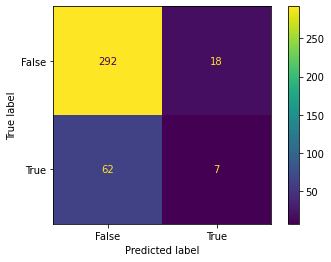

In [1113]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels=clf.classes_), display_labels=clf.classes_).plot()
plt.show()

We can see that our algorithm is quite dumb and it should be replaced or at least several experiments need to be conducted.

### Explainability

To explain model let's use shap and built-in feature importance in sklearn.

In [1114]:
import shap

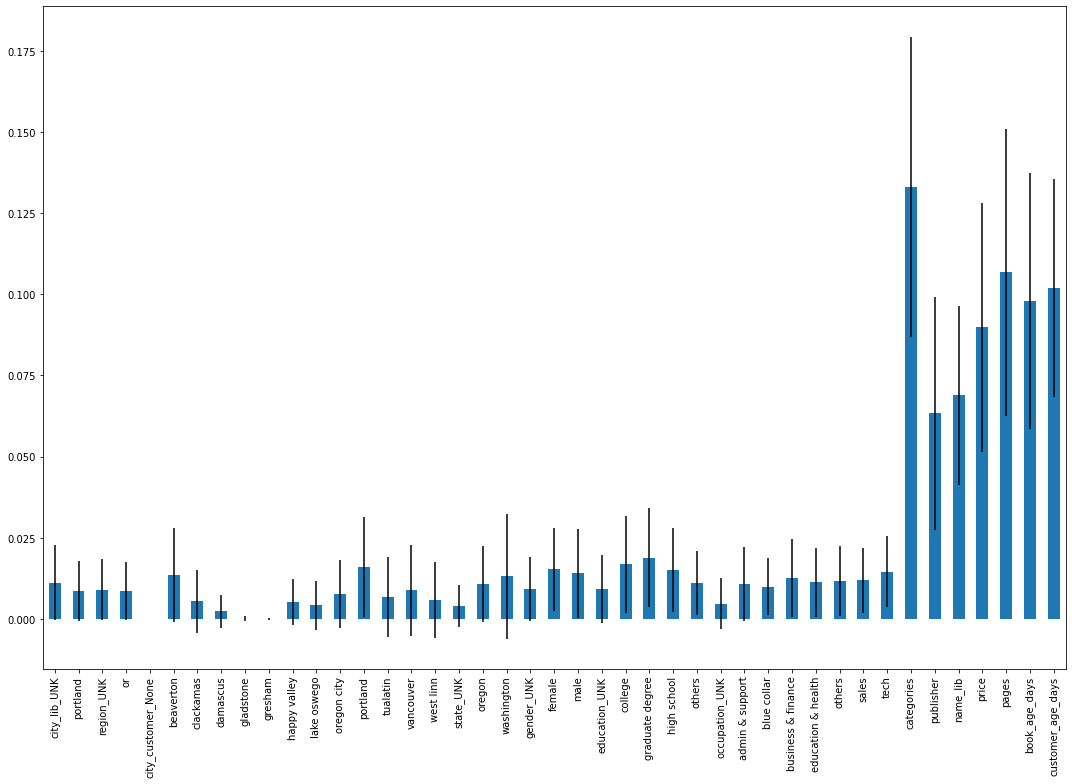

In [1043]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=my_columns)

fig, ax = plt.subplots(figsize=(15, 11))
forest_importances.plot.bar(yerr=std, ax=ax)
fig.tight_layout()

Above we can see that there are a bunch of variables that are more important for the model. Let's look into shap to find intersections.

In [1116]:
explainer = shap.TreeExplainer(clf)

Firstly let's look on right predicted delayed books and guess what make the model predict 1 instead of 0.

In [1120]:
a = y_test
a['pred'] = y_pred
a[a["pred"] == True]["pred"].index

Int64Index([ 543,  554,  990,  244,    2,  186, 1487, 1426, 1173,  378,  332,
            1244,  888,  236, 1508, 1327,  818,  841, 1162, 1243,  946,  489,
             199,  913,  837],
           dtype='int64')

In [1121]:
row = 543

shap_values = explainer.shap_values(X_test.loc[row])
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.loc[row])

In [1122]:
row = 554

shap_values = explainer.shap_values(X_test.loc[row])
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.loc[row])

In [1123]:
row = 990

shap_values = explainer.shap_values(X_test.loc[row])
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.loc[row])

In [1124]:
row = 244

shap_values = explainer.shap_values(X_test.loc[row])
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.loc[row])

In [1125]:
row = 2

shap_values = explainer.shap_values(X_test.loc[row])
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.loc[row])

In [1126]:
row = 186

shap_values = explainer.shap_values(X_test.loc[row])
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.loc[row])

As we can see the most influential variables are: publisher, categories, pages and price. Let's see how it works on regression problem.

In [1128]:
import statsmodels.api as sm   

log_reg = sm.Logit(y_train, X_train[["publisher", "categories", "pages", "price"]]).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.491529
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             is_delayed   No. Observations:                 1135
Model:                          Logit   Df Residuals:                     1131
Method:                           MLE   Df Model:                            3
Date:                Fri, 12 Aug 2022   Pseudo R-squ.:                -0.04065
Time:                        21:23:55   Log-Likelihood:                -557.88
converged:                       True   LL-Null:                       -536.09
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
publisher      1.0138      0.945      1.073      0.283      -0.839       2.866
categories     2.8435      0.

As we can see significantly impacts categories and page variables according to P-value. Let's see how it looks in the data.

### Post-analysis

We'll compare two subsets: Books that were delayed and that were not.

In [1129]:
not_delayed = df[df.is_delayed == False]
delayed = df[df.is_delayed == True]

In [1130]:
not_delayed.categories.value_counts() / not_delayed.shape[0]

UNK                                          0.134583
Business & Economics                         0.126917
Medicine                                     0.080068
Advertising                                  0.057070
Science                                      0.048552
                                               ...   
Information storage and retrieval systems    0.001704
Banking law                                  0.000852
Utah                                         0.000852
Mathematics                                  0.000852
Financial services industry                  0.000852
Name: categories, Length: 88, dtype: float64

In [1131]:
delayed.categories.value_counts() / delayed.shape[0]

UNK                     0.182510
Business & Economics    0.121673
Advertising             0.060837
Science                 0.060837
Medicine                0.041825
                          ...   
Gases                   0.003802
Marine resources        0.003802
Classification          0.003802
Internal medicine       0.003802
Philosophy              0.003802
Name: categories, Length: 67, dtype: float64

In [1132]:
not_delayed.pages.describe()

count    1174.000000
mean      575.546848
std       169.123826
min       115.000000
25%       458.000000
50%       570.000000
75%       682.000000
max       967.000000
Name: pages, dtype: float64

In [1133]:
delayed.pages.describe()

count    263.000000
mean     627.722433
std      169.316258
min      115.000000
25%      527.000000
50%      648.000000
75%      744.000000
max      967.000000
Name: pages, dtype: float64

We can see above those people who tend to return books late usually take more Advertising and Science books and these books contain more pages on average.

- Are there any factors you can find that are connected with late returns?

As we can see, from tables and plots pages factor the most intuitive and indeed significant - the more mages the more likely that the book will be returned late. Also, we can see that Advertising and Science books tend to be returned later. 

- What would you recommend the library do to mitigate the risks you find? 

I'd recommend notifying one more time customers about library rules regarding book returning in cases they borrow books that are longer than 400 pages and Advertising and Science books

- How would you present your findings to them to get buy-in?

I'd make a presentation where I show pictures with Shapley values and the results of the regression. I'd make an emphasis on interpretation.


### Final thoughts

- It's a lot depend on data preprocessing, probably I've made some mistakes there.
- The model should be replaced
- There might be more hypotheses tested and I'm sure that I didn't catch the core of problem.